**Passos iniciais**

In [163]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from yellowbrick.classifier import ConfusionMatrix

In [164]:
data = pd.read_csv('heart-disease.csv')

**Pré-Processamento dos dados**

In [165]:
attributesName = data.columns[:-1]

Verificando Duplicatas e Amostras inconsistentes

In [166]:
#Criando um dataframe com os registros duplicados em todas as colunas, menos a ultima. 
df_duplicates = data[data.duplicated(subset=attributesName, keep=False)]

if len(df_duplicates) > 0:
    print('\nAmostras redundantes ou inconsistentes:')
    display(df_duplicates)
else:
    print('Não existem valores duplicados')


Amostras redundantes ou inconsistentes:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
163,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1
164,38,1,2,138,175,0,1,173,0,0.0,2,4,2,1


Caso exista, removê-los

In [167]:
data = data.drop_duplicates(keep='first')

Verificar se as amostras foram removidas

In [168]:
#Criando um dataframe com os registros duplicados em todas as colunas, menos a ultima. 
df_duplicates = data[data.duplicated(subset=attributesName, keep=False)]

if len(df_duplicates) > 0:
    print('\nAmostras redundantes ou inconsistentes:')
    display(df_duplicates)
else:
    print('Não existem valores duplicados')

Não existem valores duplicados


**Estatística dos Dados**

In [169]:
dataInfo = data.describe()
display(dataInfo)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,302.00000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000,302.000000
mean,54.42053,0.682119,0.963576,131.602649,246.500000,0.149007,0.526490,149.569536,0.327815,1.043046,1.397351,0.718543,2.314570,0.543046
std,9.04797,0.466426,1.032044,17.563394,51.753489,0.356686,0.526027,22.903527,0.470196,1.161452,0.616274,1.006748,0.613026,0.498970
min,29.00000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.00000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.250000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.50000,1.000000,1.000000,130.000000,240.500000,0.000000,1.000000,152.500000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.00000,1.000000,2.000000,140.000000,274.750000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.00000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


Normalizando os dados

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


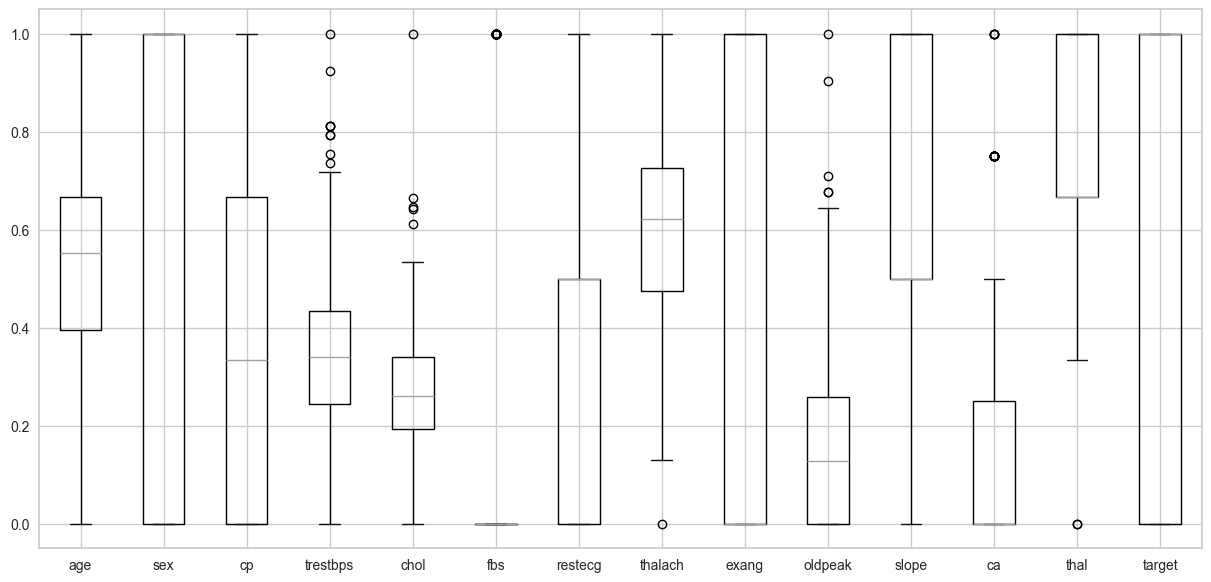

In [170]:
from sklearn.preprocessing import MinMaxScaler

def normaliza(df):
    # Inicializa o MinMaxScaler
    scaler = MinMaxScaler()

    # Seleciona todas as colunas, exceto a última (target class)
    normalizeColumns = df.iloc[:, :-1]

    # Ajusta e transforma os dados com o MinMaxScaler
    df_normalized = pd.DataFrame(scaler.fit_transform(normalizeColumns), columns=normalizeColumns.columns)

    # Adiciona a última coluna não normalizada ao DataFrame normalizado
    df_normalized[df.columns[-1]] = df[df.columns[-1]].values  # Usar .values para garantir a compatibilidade

    return df_normalized

data = normaliza(data)

# Verificar se há NaNs na target class após a normalização
print(data.isnull().sum())

# Gera um boxplot para cada atributo
data.boxplot(figsize=(15,7))
plt.show()


In [171]:
Class = data.columns[-1]
np.unique(data[Class], return_counts=True)

(array([0, 1]), array([138, 164]))

Removendo Outliers

In [172]:
dataInfo = data.describe()

# Inicializa um DataFrame limpo
data_clean = data.copy()

outliers_removed = pd.DataFrame()

# Para todas as colunas numéricas
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns

for col in numerical_cols:
    Q1 = dataInfo[col]['25%']
    Q3 = dataInfo[col]['75%']
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    

    # Identificando os outliers
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    
    # Armazenando os outliers removidos
    outliers_removed = pd.concat([outliers_removed, outliers])

    # Filtrando os dados para remover outliers
    data_clean = data_clean[(data_clean[col] >= lower_bound) & (data_clean[col] <= upper_bound)]


display(data_clean)

print('\n Os outliers removidos: ')
display(outliers_removed)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
1,0.166667,1.0,0.666667,0.339623,0.283105,0.0,0.5,0.885496,0.0,0.564516,0.0,0.00,0.666667,1
2,0.250000,0.0,0.333333,0.339623,0.178082,0.0,0.0,0.770992,0.0,0.225806,1.0,0.00,0.666667,1
3,0.562500,1.0,0.333333,0.245283,0.251142,0.0,0.5,0.816794,0.0,0.129032,1.0,0.00,0.666667,1
4,0.583333,0.0,0.000000,0.245283,0.520548,0.0,0.5,0.702290,1.0,0.096774,1.0,0.00,0.666667,1
5,0.583333,1.0,0.000000,0.433962,0.150685,0.0,0.5,0.587786,0.0,0.064516,0.5,0.00,0.333333,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,0.708333,0.0,0.000000,0.283019,0.162100,0.0,0.5,0.496183,1.0,0.000000,0.5,0.00,0.666667,0
297,0.583333,0.0,0.000000,0.433962,0.262557,0.0,0.5,0.396947,1.0,0.032258,0.5,0.00,1.000000,0
298,0.333333,1.0,1.000000,0.150943,0.315068,0.0,0.5,0.465649,0.0,0.193548,0.5,0.00,1.000000,0
300,0.583333,1.0,0.000000,0.339623,0.011416,0.0,0.5,0.335878,1.0,0.193548,0.5,0.25,1.000000,0



 Os outliers removidos: 


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
8,0.479167,1.0,0.666667,0.735849,0.166667,1.0,0.5,0.694656,0.0,0.080645,1.0,0.00,1.000000,1
101,0.625000,1.0,1.000000,0.792453,0.328767,0.0,0.0,0.564885,0.0,0.677419,0.0,0.00,1.000000,1
110,0.729167,0.0,0.000000,0.811321,0.454338,0.0,0.5,0.633588,1.0,0.000000,1.0,0.00,0.666667,1
202,0.812500,1.0,0.666667,0.811321,0.337900,1.0,0.0,0.603053,1.0,0.258065,0.5,0.00,1.000000,0
222,0.562500,0.0,0.000000,1.000000,0.369863,1.0,0.0,0.473282,1.0,0.645161,0.0,0.50,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,0.333333,1.0,0.000000,0.452830,0.417808,0.0,0.0,0.580153,1.0,0.000000,0.5,0.75,1.000000,0
266,0.416667,1.0,0.666667,0.226415,0.052511,0.0,0.0,0.419847,0.0,0.129032,1.0,0.75,0.666667,0
290,0.604167,1.0,0.000000,0.188679,0.438356,0.0,1.0,0.526718,0.0,0.709677,0.0,0.75,0.333333,0
48,0.500000,0.0,0.666667,0.320755,0.205479,0.0,0.0,0.335878,0.0,0.000000,1.0,0.00,0.000000,1


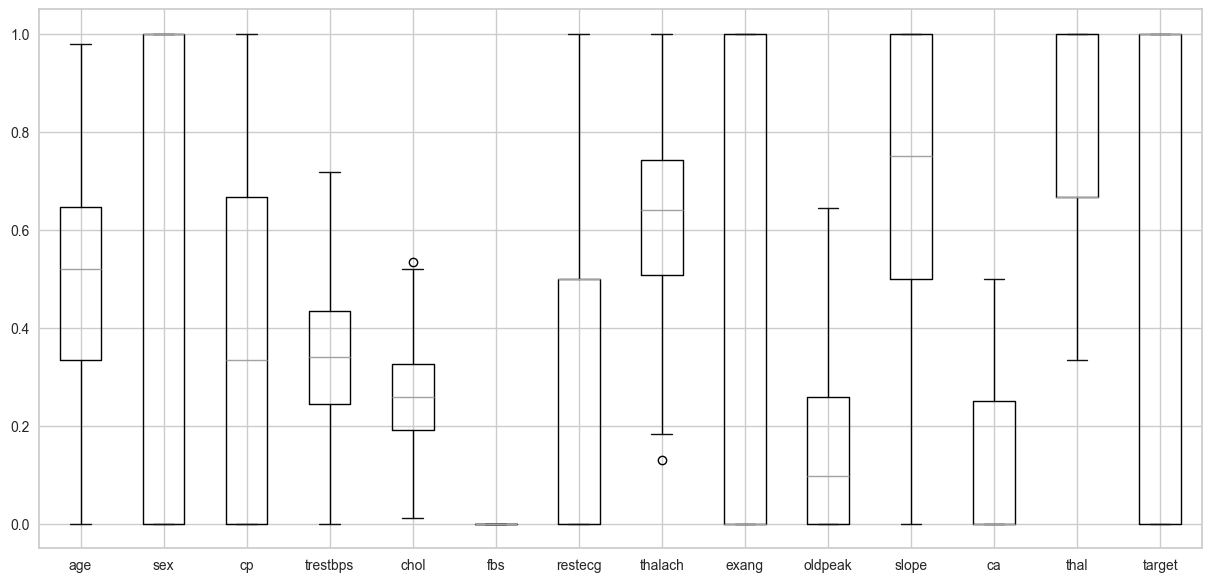

In [173]:
data_clean.boxplot(figsize=(15, 7))
plt.show()

Inputando dados usando o KNN para correção de outliers

In [174]:
from sklearn.impute import KNNImputer

dataInfo = data.describe()

# Inicializa um DataFrame limpo
data_knn = data.copy()


outliers_removed = pd.DataFrame()

# Para todas as colunas numéricas
numerical_cols = data.select_dtypes(include=['float64', 'int64']).columns

# Inicializa o KNNImputer
imputer = KNNImputer(n_neighbors=5)  

for col in numerical_cols:
    Q1 = dataInfo[col]['25%']
    Q3 = dataInfo[col]['75%']
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identificando os outliers
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    
    # Armazenando os outliers removidos
    outliers_removed = pd.concat([outliers_removed, outliers])
    
    # Criar uma cópia da coluna original para imputação
    temp_column = data_knn[col].copy()
    
    # Imputar valores nos outliers
    outlier_indices = temp_column[(temp_column < lower_bound) | (temp_column > upper_bound)].index
    temp_column[outlier_indices] = None  # Definir outliers como None para imputação
    
    # Ajustar a coluna com imputação KNN
    temp_column_imputed = imputer.fit_transform(temp_column.values.reshape(-1, 1))
    
    # Atualizar a coluna no DataFrame limpo
    data_knn[col] = temp_column_imputed

display(data_knn)
display(outliers_removed)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,0.708333,1.0,1.000000,0.481132,0.244292,0.0,0.0,0.603053,0.0,0.370968,0.0,0.00,0.333333,1.0
1,0.166667,1.0,0.666667,0.339623,0.283105,0.0,0.5,0.885496,0.0,0.564516,0.0,0.00,0.666667,1.0
2,0.250000,0.0,0.333333,0.339623,0.178082,0.0,0.0,0.770992,0.0,0.225806,1.0,0.00,0.666667,1.0
3,0.562500,1.0,0.333333,0.245283,0.251142,0.0,0.5,0.816794,0.0,0.129032,1.0,0.00,0.666667,1.0
4,0.583333,0.0,0.000000,0.245283,0.520548,0.0,0.5,0.702290,1.0,0.096774,1.0,0.00,0.666667,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,0.583333,0.0,0.000000,0.433962,0.262557,0.0,0.5,0.396947,1.0,0.032258,0.5,0.00,1.000000,0.0
298,0.333333,1.0,1.000000,0.150943,0.315068,0.0,0.5,0.465649,0.0,0.193548,0.5,0.00,1.000000,0.0
299,0.812500,1.0,0.000000,0.471698,0.152968,0.0,0.5,0.534351,0.0,0.548387,0.5,0.50,1.000000,0.0
300,0.583333,1.0,0.000000,0.339623,0.011416,0.0,0.5,0.335878,1.0,0.193548,0.5,0.25,1.000000,0.0


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
8,0.479167,1.0,0.666667,0.735849,0.166667,1.0,0.5,0.694656,0.0,0.080645,1.0,0.00,1.000000,1
101,0.625000,1.0,1.000000,0.792453,0.328767,0.0,0.0,0.564885,0.0,0.677419,0.0,0.00,1.000000,1
110,0.729167,0.0,0.000000,0.811321,0.454338,0.0,0.5,0.633588,1.0,0.000000,1.0,0.00,0.666667,1
202,0.812500,1.0,0.666667,0.811321,0.337900,1.0,0.0,0.603053,1.0,0.258065,0.5,0.00,1.000000,0
222,0.562500,0.0,0.000000,1.000000,0.369863,1.0,0.0,0.473282,1.0,0.645161,0.0,0.50,1.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
254,0.333333,1.0,0.000000,0.452830,0.417808,0.0,0.0,0.580153,1.0,0.000000,0.5,0.75,1.000000,0
266,0.416667,1.0,0.666667,0.226415,0.052511,0.0,0.0,0.419847,0.0,0.129032,1.0,0.75,0.666667,0
290,0.604167,1.0,0.000000,0.188679,0.438356,0.0,1.0,0.526718,0.0,0.709677,0.0,0.75,0.333333,0
48,0.500000,0.0,0.666667,0.320755,0.205479,0.0,0.0,0.335878,0.0,0.000000,1.0,0.00,0.000000,1


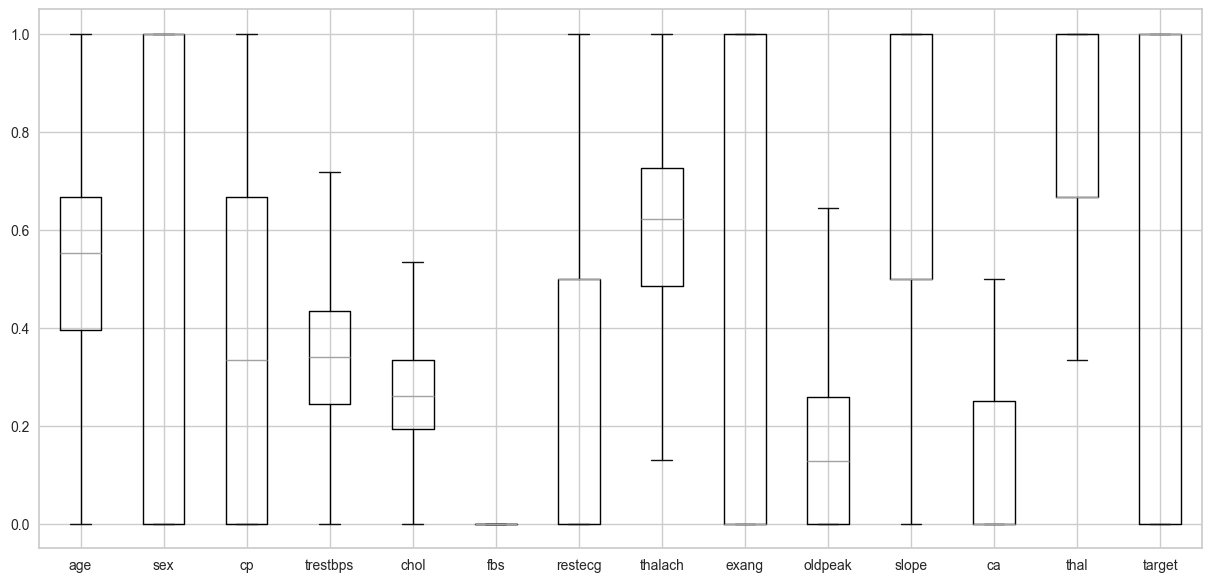

In [175]:
data_knn.boxplot(figsize=(15, 7))
plt.show()

**Separação de Amostras**

In [176]:
Class_Clean = data_clean.columns[-1]
np.unique(data[Class_Clean], return_counts=True)

Class_KNN = data_knn.columns[-1]
np.unique(data[Class_KNN], return_counts=True)

(array([0, 1]), array([138, 164]))

In [177]:
sns.countplot(x = data_clean[Class_Clean])
sns.countplot(x = data_knn[Class_KNN])

<Axes: xlabel='target', ylabel='count'>

**Separando os atributos de entrada e de classe**

In [178]:
x_prev_clean = data_clean.iloc[:, :-1]
print(x_prev_clean)

x_prev_knn = data_knn.iloc[:, :-1]
print(x_prev_knn)

          age  sex        cp  trestbps      chol  fbs  restecg   thalach  \
1    0.166667  1.0  0.666667  0.339623  0.283105  0.0      0.5  0.885496   
2    0.250000  0.0  0.333333  0.339623  0.178082  0.0      0.0  0.770992   
3    0.562500  1.0  0.333333  0.245283  0.251142  0.0      0.5  0.816794   
4    0.583333  0.0  0.000000  0.245283  0.520548  0.0      0.5  0.702290   
5    0.583333  1.0  0.000000  0.433962  0.150685  0.0      0.5  0.587786   
..        ...  ...       ...       ...       ...  ...      ...       ...   
295  0.708333  0.0  0.000000  0.283019  0.162100  0.0      0.5  0.496183   
297  0.583333  0.0  0.000000  0.433962  0.262557  0.0      0.5  0.396947   
298  0.333333  1.0  1.000000  0.150943  0.315068  0.0      0.5  0.465649   
300  0.583333  1.0  0.000000  0.339623  0.011416  0.0      0.5  0.335878   
301  0.583333  0.0  0.333333  0.339623  0.251142  0.0      0.0  0.786260   

     exang   oldpeak  slope    ca      thal  
1      0.0  0.564516    0.0  0.00  0.6666

In [179]:
y_prev_clean = data_clean.iloc[:,-1]
print(y_prev_clean)

y_prev_knn = data_knn.iloc[:,-1]
print(y_prev_knn)

1      1
2      1
3      1
4      1
5      1
      ..
295    0
297    0
298    0
300    0
301    0
Name: target, Length: 228, dtype: int64
0      1.0
1      1.0
2      1.0
3      1.0
4      1.0
      ... 
297    0.0
298    0.0
299    0.0
300    0.0
301    0.0
Name: target, Length: 302, dtype: float64


**Separação de dados**

In [180]:
print(x_prev_clean.shape)
print(x_prev_knn.shape)

(228, 13)
(302, 13)


In [181]:
print(y_prev_clean.shape)
print(y_prev_knn.shape)

(228,)
(302,)


In [182]:
from sklearn.model_selection import train_test_split
#colocando random state em 0 para testes mais consistentes
x_treino_knn, x_teste_knn, y_treino_knn, y_teste_knn = train_test_split(x_prev_knn, y_prev_knn, test_size = 0.20, random_state = 0)

x_treino_clean, x_teste_clean, y_treino_clean, y_teste_clean = train_test_split(x_prev_clean, y_prev_clean, test_size = 0.20, random_state = 0)

**Area de treino dos modelos**

*Naive Bayes*

DataSet com os outliers removidos

In [183]:
from sklearn.naive_bayes import GaussianNB
modelo = GaussianNB()
modelo.fit(x_treino_clean, y_treino_clean)
previsoes = modelo.predict(x_teste_clean)

In [184]:
confusion_matrix(y_teste_clean, previsoes)

array([[21,  3],
       [ 7, 15]])

In [185]:
print(classification_report(y_teste_clean, previsoes))

              precision    recall  f1-score   support

           0       0.75      0.88      0.81        24
           1       0.83      0.68      0.75        22

    accuracy                           0.78        46
   macro avg       0.79      0.78      0.78        46
weighted avg       0.79      0.78      0.78        46



DataSet com KNN

In [186]:
from sklearn.naive_bayes import GaussianNB
modelo = GaussianNB()
modelo.fit(x_treino_knn, y_treino_knn)
previsoes = modelo.predict(x_teste_knn)

In [187]:
confusion_matrix(y_teste_knn, previsoes)

array([[23,  4],
       [ 3, 31]])

In [188]:
print(classification_report(y_teste_knn, previsoes))

              precision    recall  f1-score   support

         0.0       0.88      0.85      0.87        27
         1.0       0.89      0.91      0.90        34

    accuracy                           0.89        61
   macro avg       0.89      0.88      0.88        61
weighted avg       0.89      0.89      0.88        61



**Decision Tree**

DataSet com os Outliers removidos

In [189]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

params = {
    'criterion':  ['gini', 'entropy', 'log_loss'],
    'splitter': ['random'],
    'max_depth':  [None, 2, 4, 6, 8, 10],
    'max_features': [None, 'sqrt', 'log2', 0.2, 0.4, 0.6, 0.8],
}

modelo = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(),
    param_distributions=params,
    cv=10,
    n_jobs=5,
    verbose=1,
)



In [190]:
modelo.fit(x_treino_clean, y_treino_clean)
print(modelo.best_params_)
print(modelo.best_score_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
{'splitter': 'random', 'max_features': 0.4, 'max_depth': 6, 'criterion': 'entropy'}
0.8406432748538011


In [191]:
X = data_clean.drop('target', axis=1)  # Features
y = data_clean['target']                # Target

In [192]:
modelo= DecisionTreeClassifier(**modelo.best_params_)
modelo.fit(x_treino_clean, y_treino_clean)

DecisionTreeClassifier(criterion='entropy', max_depth=6, max_features=0.4,
                       splitter='random')

In [193]:
previsoes = modelo.predict(x_teste_clean)
accuracy_score(y_teste_clean,previsoes)

0.8260869565217391

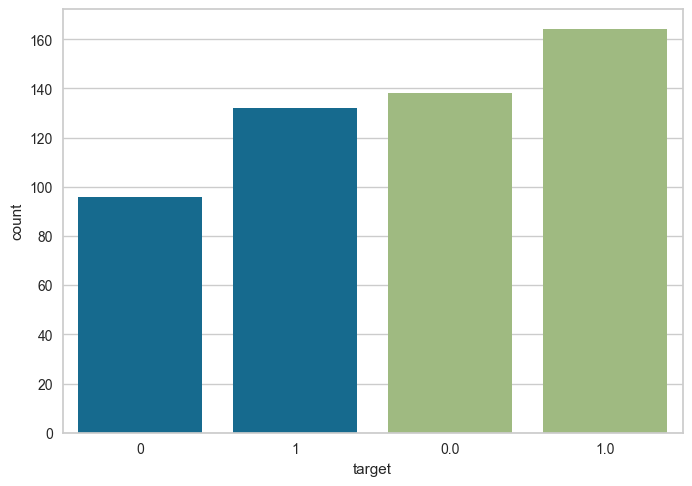

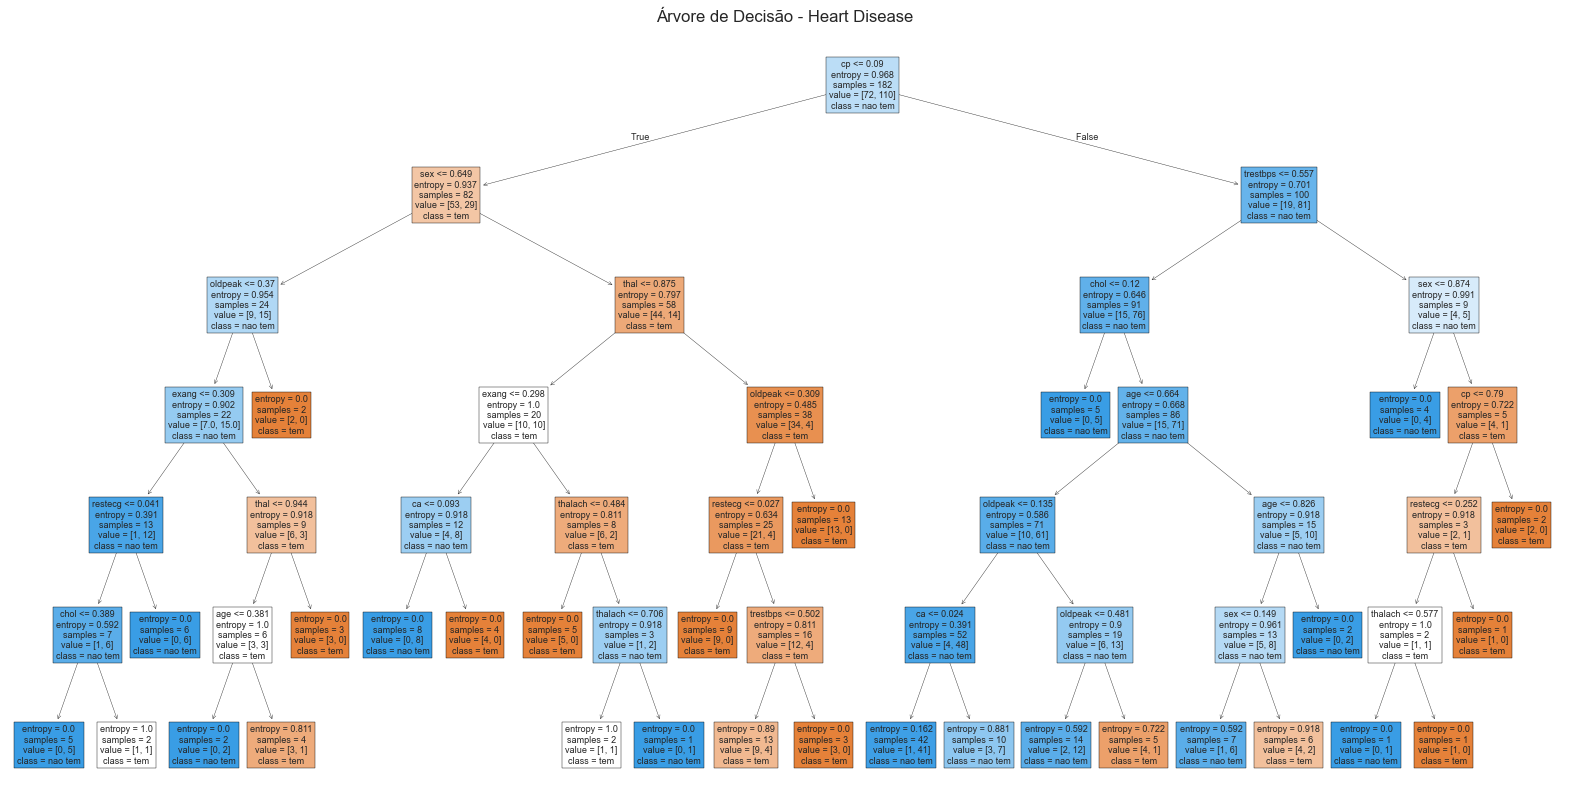

In [194]:
from sklearn import tree

plt.figure(figsize=(20,10))
tree.plot_tree(modelo, filled=True, feature_names=X.columns, class_names=['tem', 'nao tem'])
plt.title("Árvore de Decisão - Heart Disease")
plt.show()

In [195]:
confusion_matrix(y_teste_clean, previsoes)

array([[20,  4],
       [ 4, 18]])

In [196]:
print(classification_report(y_teste_clean, previsoes))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83        24
           1       0.82      0.82      0.82        22

    accuracy                           0.83        46
   macro avg       0.83      0.83      0.83        46
weighted avg       0.83      0.83      0.83        46



DataSet com o KNN

In [197]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
params = {
    'criterion':  ['gini', 'entropy', 'log_loss'],
    'splitter': ['random'],
    'max_depth':  [None, 2, 4, 6, 8, 10],
    'max_features': [None, 'sqrt', 'log2', 0.2, 0.4, 0.6, 0.8],
}

modelo = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(),
    param_distributions=params,
    cv=10,
    n_jobs=5,
    verbose=1,
)

In [198]:
modelo.fit(x_treino_knn, y_treino_knn)
print(modelo.best_params_)
print(modelo.best_score_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
{'splitter': 'random', 'max_features': 0.4, 'max_depth': 4, 'criterion': 'entropy'}
0.7718333333333333


In [199]:
modelo= DecisionTreeClassifier(**modelo.best_params_)
modelo.fit(x_treino_knn, y_treino_knn)


DecisionTreeClassifier(criterion='entropy', max_depth=4, max_features=0.4,
                       splitter='random')

In [200]:
X = data_knn.drop('target', axis=1)  # Features
y = data_knn['target']                # Target

In [201]:
previsoes = modelo.predict(x_teste_knn)
accuracy_score(y_teste_knn,previsoes)

0.8360655737704918

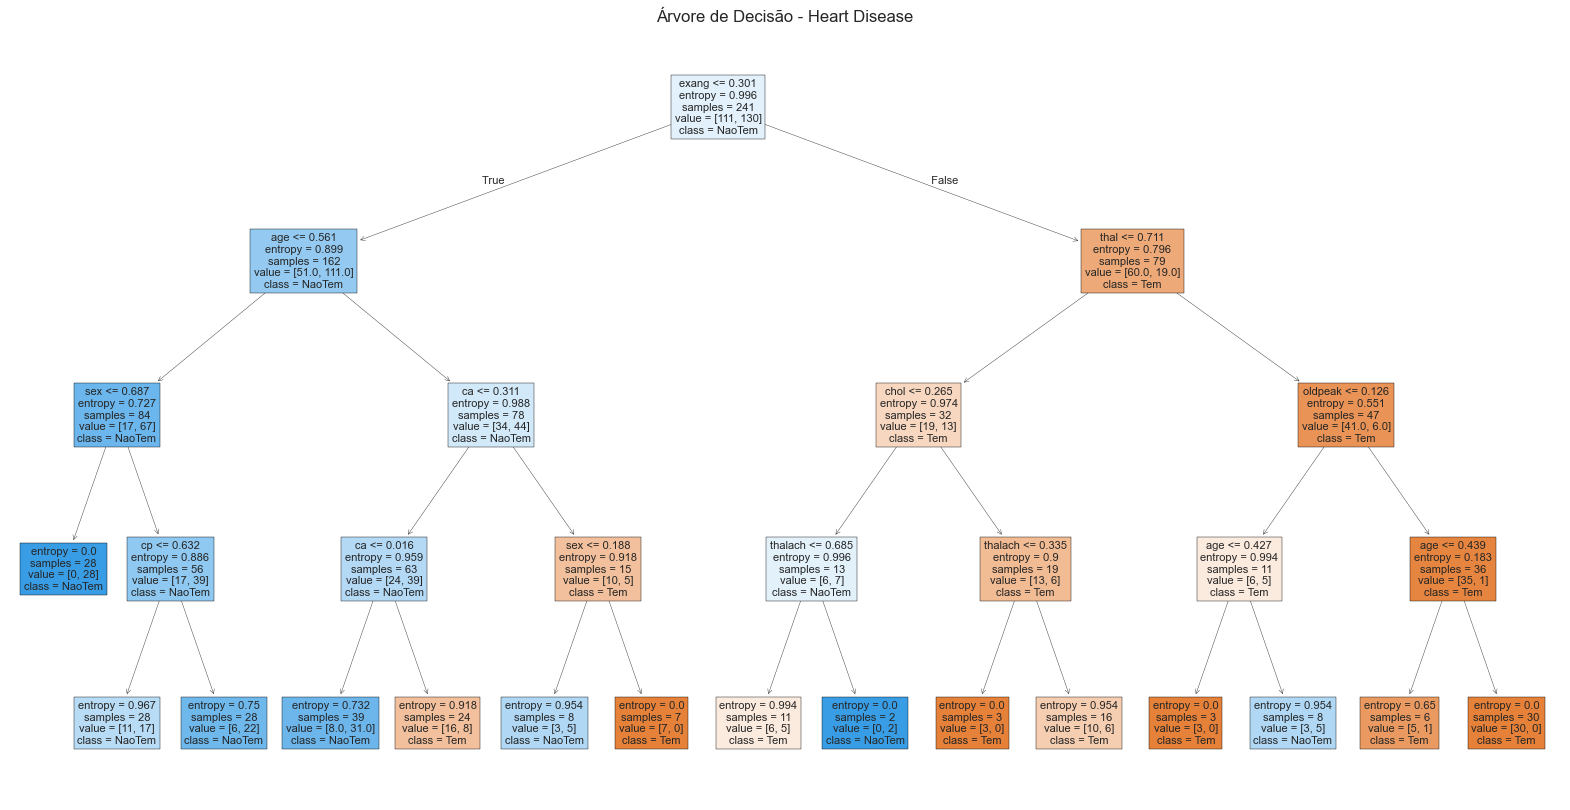

In [202]:
from sklearn import tree

plt.figure(figsize=(20,10))
tree.plot_tree(modelo, filled=True, feature_names=X.columns, class_names=['Tem', 'NaoTem'])
plt.title("Árvore de Decisão - Heart Disease")
plt.show()

In [203]:
confusion_matrix(y_teste_knn, previsoes)

array([[24,  3],
       [ 7, 27]])

In [204]:
print(classification_report(y_teste_knn, previsoes))

              precision    recall  f1-score   support

         0.0       0.77      0.89      0.83        27
         1.0       0.90      0.79      0.84        34

    accuracy                           0.84        61
   macro avg       0.84      0.84      0.84        61
weighted avg       0.84      0.84      0.84        61



**Random Forest**

DataSet com os outliers removidos

In [205]:
from sklearn.ensemble import RandomForestClassifier
params = {
    'criterion':  ['gini', 'entropy', 'log_loss'],
    'n_estimators': [80,90,95,100],
    'max_features': [None, 'sqrt', 1.5,2,3],
    'random_state' : [None, 21, 42],
}

modelo = RandomizedSearchCV(
    estimator=RandomForestClassifier(),
    param_distributions=params,
    cv=10,
    n_jobs=5,
    verbose=1,
)


In [206]:
modelo.fit(x_treino_clean, y_treino_clean)
print(modelo.best_params_)
print(modelo.best_score_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
{'random_state': 21, 'n_estimators': 80, 'max_features': 'sqrt', 'criterion': 'entropy'}
0.8511695906432747


c:\Users\kntpr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
50 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
42 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\kntpr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\kntpr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\kntpr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.p

In [207]:
modelo= RandomForestClassifier(**modelo.best_params_)
modelo.fit(x_treino_clean, y_treino_clean)

RandomForestClassifier(criterion='entropy', n_estimators=80, random_state=21)

In [208]:
previsoes = modelo.predict(x_teste_clean)
accuracy_score(y_teste_clean,previsoes)

0.782608695652174

In [209]:
confusion_matrix(y_teste_clean, previsoes)

array([[21,  3],
       [ 7, 15]])

In [210]:
print(classification_report(y_teste_clean, previsoes))

              precision    recall  f1-score   support

           0       0.75      0.88      0.81        24
           1       0.83      0.68      0.75        22

    accuracy                           0.78        46
   macro avg       0.79      0.78      0.78        46
weighted avg       0.79      0.78      0.78        46



DataSet com o KNN

In [211]:
from sklearn.ensemble import RandomForestClassifier
params = {
    'criterion':  ['gini', 'entropy', 'log_loss'],
    'n_estimators': [80,90,95,100],
    'max_features': [None, 'sqrt', 1.5,2,3],
    'random_state' : [None, 21, 42],
}

modelo = RandomizedSearchCV(
    estimator=RandomForestClassifier(),
    param_distributions=params,
    cv=10,
    n_jobs=5,
    verbose=1,
)

In [212]:
modelo.fit(x_treino_knn, y_treino_knn)
print(modelo.best_params_)
print(modelo.best_score_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
{'random_state': None, 'n_estimators': 90, 'max_features': 2, 'criterion': 'entropy'}
0.8383333333333333


c:\Users\kntpr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
10 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\kntpr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\kntpr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\kntpr\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.p

In [213]:
modelo= RandomForestClassifier(**modelo.best_params_)
modelo.fit(x_treino_knn, y_treino_knn)

RandomForestClassifier(criterion='entropy', max_features=2, n_estimators=90)

In [214]:
previsoes = modelo.predict(x_teste_knn)
accuracy_score(y_teste_knn,previsoes)

0.8688524590163934

In [215]:
confusion_matrix(y_teste_knn, previsoes)

array([[24,  3],
       [ 5, 29]])

In [216]:
print(classification_report(y_teste_knn, previsoes))

              precision    recall  f1-score   support

         0.0       0.83      0.89      0.86        27
         1.0       0.91      0.85      0.88        34

    accuracy                           0.87        61
   macro avg       0.87      0.87      0.87        61
weighted avg       0.87      0.87      0.87        61

